In [1]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using Distributions 
using IntervalSets

using HCubature
using JLD2
using CPUTime

# import Plots
# using Colors
# using ColorSchemes
using LaTeXStrings

using SpecialFunctions

# Plots.pyplot(size=(750,500))

using PyPlot
plt = PyPlot

PyPlot

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 13
BIGGER_SIZE = 13

plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
JLD2.@load "Generated_Data/test-1.jld" samples_ps

1-element Array{Symbol,1}:
 :samples_ps

In [4]:
smpl_par = hcat(samples_ps.samples...)
x = smpl_par[1,:]
y = smpl_par[2,:]
w_o = samples_ps.weights_o
w_r =  samples_ps.weights_r;


In [5]:
[sum(samples_ps.integrals), sqrt(sum((samples_ps.uncertainty).^2))]

2-element Array{Float64,1}:
 0.936511362263829
 0.005753234252229029

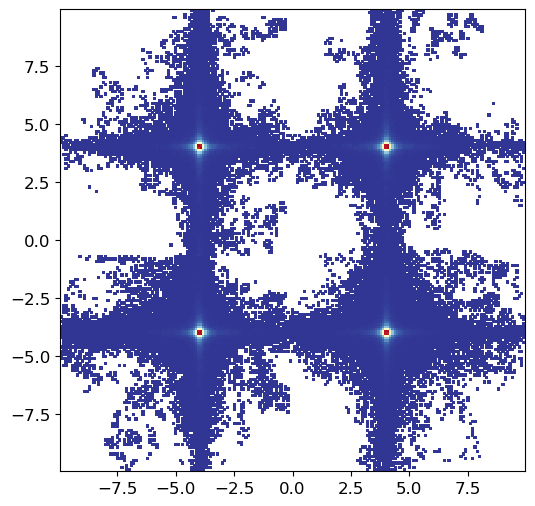

PyObject <matplotlib.collections.QuadMesh object at 0x156416d10>

In [6]:
histogram_2D_r = fit(Histogram, (x,y), weights(w_r), nbins=200)
histogram_2D_r = normalize(histogram_2D_r, mode=:probability)

fig, ax = plt.subplots(1,1, figsize=(6, 6))

img = ax.pcolormesh(midpoints(histogram_2D_r.edges[1]), midpoints(histogram_2D_r.edges[2]), replace(histogram_2D_r.weights', 0=>NaN), cmap="RdYlBu_r") #terrain_r  vmin = -0.0001, vmax=maximum_v,
# fig.colorbar(img)

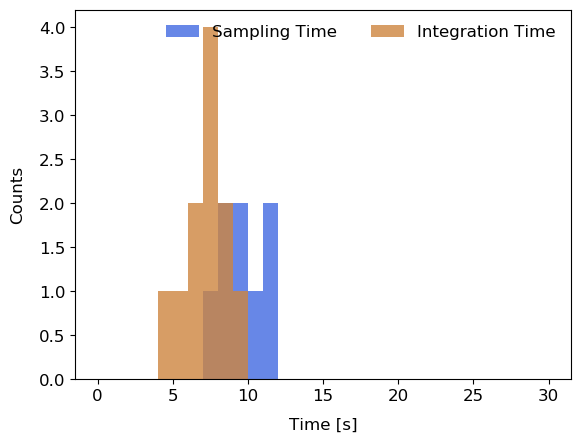

PyObject Text(24.999999999999996, 0.5, 'Counts')

In [7]:
bins=collect(0:1:30)
plt.hist(samples_ps.time_mcmc, bins, color="royalblue", label = "Sampling Time", alpha=0.8);
plt.hist(samples_ps.time_integration, bins, color="peru", label = "Integration Time", alpha=0.8);

plt.legend(loc="upper right", frameon=false, framealpha=0.8, ncol=2, )
plt.xlabel("Time [s]", labelpad=10,  size=12)
plt.ylabel("Counts", labelpad=10,  size=12)

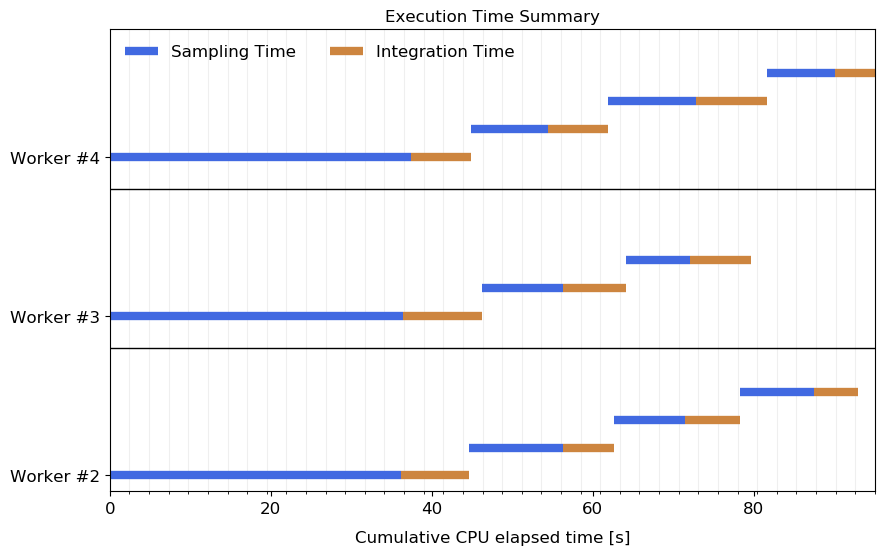

In [8]:
proc_ids = sort(unique(samples_ps.proc_id))

tmp = [sum(samples_ps.proc_id .== i) for i in proc_ids]

min_subspaces = minimum(tmp)
max_subspaces = maximum(tmp)

proc_names = ["Worker #$i" for i in proc_ids]
proc_sampling_sum = [sum(samples_ps.time_mcmc[samples_ps.proc_id .== i]) for i in proc_ids]
proc_int_sum = [sum(samples_ps.time_integration[samples_ps.proc_id .== i]) for i in proc_ids]

proc_pos = collect(1:1:length(proc_ids));
delta = 0.7 / max_subspaces

sampling_times = [samples_ps.time_mcmc[samples_ps.proc_id .== i] for i in proc_ids]
int_times = [samples_ps.time_integration[samples_ps.proc_id .== i] for i in proc_ids]

fin_positions = maximum.([cumsum(i) for i in (sampling_times .+ int_times)]);


fig, ax = plt.subplots(figsize=(10, 6))
fig.subplots_adjust(left=0.115, right=0.88)

label_1 = "Sampling Time"
label_2 = "Integration Time"

for p in 1:1:length(proc_names)
    n_subspaces = 1:1:length(sampling_times[p])
    
    cum_sum_int = cumsum(pushfirst!(sampling_times[p]+int_times[p], 0))
    
    ax.hlines([proc_pos[p] + (i-1)*delta for i in n_subspaces], cum_sum_int[1:end-1], cum_sum_int[1:end-1] .+sampling_times[p], color="royalblue", lw=6,  label=label_1)
    ax.hlines([proc_pos[p] + (i-1)*delta for i in n_subspaces], cum_sum_int[2:end] .- int_times[p], cum_sum_int[2:end], color="peru", lw=6, label=label_2)
    
    label_1 = "_nolegend_"
    label_2 = "_nolegend_"

    
end

ax.hlines(proc_pos[1:end-1].+0.8, 0, maximum(fin_positions), color="black", ls="-", lw=1, alpha=1)
ax.set_xlim(0, maximum(fin_positions))
ax.set_ylim(0.9, maximum(proc_pos)+0.8)

ax.set_yticks(proc_pos)
ax.set_yticklabels(proc_names)

ax.legend(loc="upper left", frameon=false, framealpha=0.8, ncol=2)
ax.set_xlabel("Cumulative CPU elapsed time [s]", labelpad=10,  size=12)
ax.set_title("Execution Time Summary",  size=12);


ax.set_xticks( range(0, stop=maximum(fin_positions), length=40), minor=true)
ax.grid(axis="x", which="minor", alpha=0.2, )

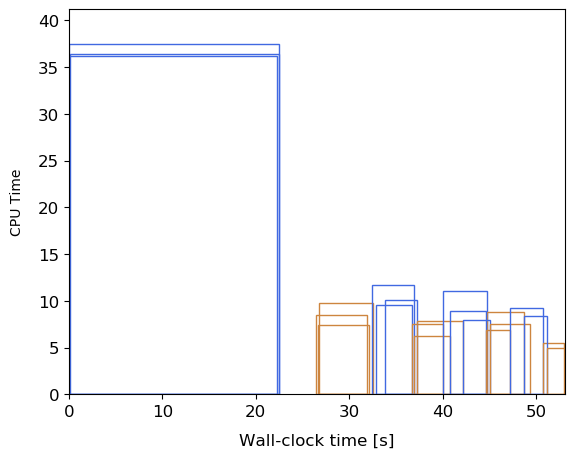

PyObject Text(0.5, 25.000000000000004, 'Wall-clock time [s]')

In [9]:
minimum_tmp = minimum(minimum(samples_ps.timestamps))

int_data = [(i .- minimum_tmp)*10^-9  for i in samples_ps.timestamps];

maximum_wc_time = maximum(maximum(int_data))
maximum_cpu_time = maximum([samples_ps.time_mcmc..., samples_ps.time_integration...])

proc_ids = sort(unique(samples_ps.proc_id))
n_workers = length(proc_ids)

x_min = 0
x_max = maximum_wc_time
y_min = 0
y_max = maximum_cpu_time + 0.1*maximum_cpu_time

# x_min = 0
# x_max = maximum_wc_time
# y_min = 0
# y_max = 10

fig, ax = plt.subplots(1,1, figsize=(9, 5))

for (i,j) in enumerate(int_data)
    
    r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], samples_ps.time_mcmc[i], fill=false, linewidth=1, color="royalblue", alpha=1) 
    ax.add_patch(r1)
    
    r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], samples_ps.time_integration[i], fill=false, linewidth=1, color="peru", alpha=1) 
    ax.add_patch(r2)
    
end

ax.set_xlim(x_min, x_max);
ax.set_ylim(y_min, y_max);
ax.axes.set_aspect("equal")
ax.set_ylabel("CPU Time", labelpad=10,  size=10)
ax.set_xlabel("Wall-clock time [s]", labelpad=10,  size=12)

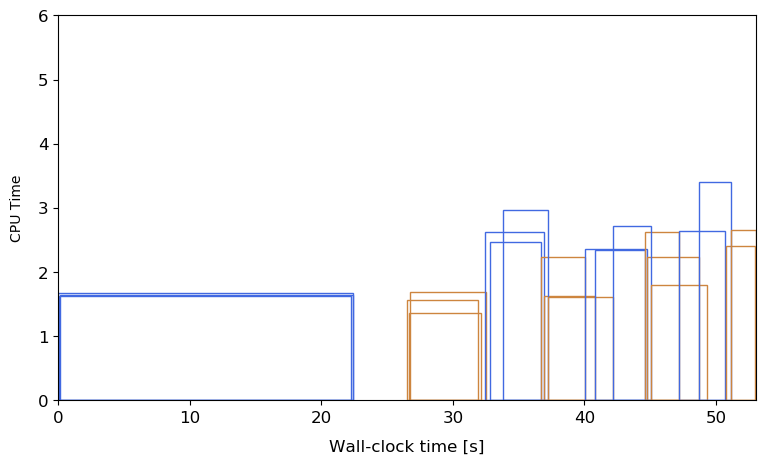

PyObject Text(0.5, 25.000000000000004, 'Wall-clock time [s]')

In [10]:
minimum_tmp = minimum(minimum(samples_ps.timestamps))

int_data = [(i .- minimum_tmp)*10^-9  for i in samples_ps.timestamps];

maximum_wc_time = maximum(maximum(int_data))
maximum_cpu_time = maximum([samples_ps.time_mcmc..., samples_ps.time_integration...])

proc_ids = sort(unique(samples_ps.proc_id))
n_workers = length(proc_ids)

x_min = 0
x_max = maximum_wc_time
y_min = 0
y_max = maximum_cpu_time + 0.1*maximum_cpu_time

# x_min = 0
# x_max = maximum_wc_time
# y_min = 0
# y_max = 10

fig, ax = plt.subplots(1,1, figsize=(9, 5))

for (i,j) in enumerate(int_data)
    
    r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], samples_ps.time_mcmc[i]/(j[2]-j[1]), fill=false, linewidth=1, color="royalblue", alpha=1) 
    ax.add_patch(r1)
    
    r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], samples_ps.time_integration[i]/(j[4]-j[3]), fill=false, linewidth=1, color="peru", alpha=1) 
    ax.add_patch(r2)
    
end

ax.set_xlim(x_min, x_max);
ax.set_ylim(y_min, 6);

ax.set_ylabel("CPU Time", labelpad=10,  size=10)
ax.set_xlabel("Wall-clock time [s]", labelpad=10,  size=12)

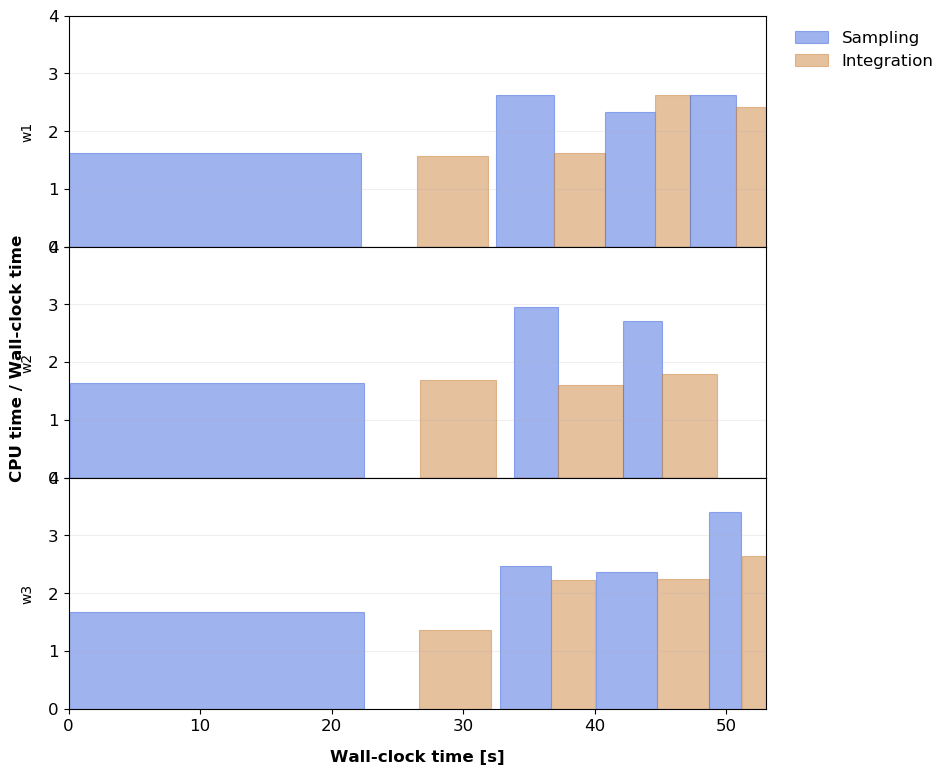

PyObject Text(0.5, 24.999999999999996, 'Wall-clock time [s]')

In [11]:
minimum_tmp = minimum(minimum(samples_ps.timestamps))

int_data = [(i .- minimum_tmp)*10^-9  for i in samples_ps.timestamps];

maximum_wc_time = maximum(maximum(int_data))
maximum_cpu_time = maximum([samples_ps.time_mcmc..., samples_ps.time_integration...])

proc_ids = sort(unique(samples_ps.proc_id))
n_workers = length(proc_ids)

x_min = 0
x_max = maximum_wc_time
y_min = 0
y_max = maximum_cpu_time + 0.1*maximum_cpu_time

# x_min = 0
# x_max = maximum_wc_time
# y_min = 0
# y_max = 10

label_1 = "Sampling"
label_2 = "Integration"

fig, ax = plt.subplots(n_workers,1, sharex=true, figsize=(n_workers*3, 9))
fig.subplots_adjust(hspace=0.0, wspace=0.00)
# fig.text(0.0, 0.5, "common Y", va="center", rotation="vertical")

y_max_tmp = []

for (i,j) in enumerate(int_data)
    
    r1 = matplotlib.patches.Rectangle([j[1], 0.0], j[2]-j[1], samples_ps.time_mcmc[i]/(j[2]-j[1]), fill=true, 
        linewidth=0.8, color="royalblue", alpha=0.5, label=label_1) 
    ax[samples_ps.proc_id[i] - 1].add_patch(r1)
    
    r2 = matplotlib.patches.Rectangle([j[3], 0.0], j[4]-j[3], samples_ps.time_integration[i]/(j[4]-j[3]), 
        fill=true, linewidth=0.8, color="peru", alpha=0.5, label=label_2) 
    ax[samples_ps.proc_id[i] - 1].add_patch(r2)
    
    push!(y_max_tmp, samples_ps.time_mcmc[i]/(j[2]-j[1]))
    push!(y_max_tmp, samples_ps.time_integration[i]/(j[4]-j[3]))
    
    label_1 = "_nolegend_"
    label_2 = "_nolegend_"
end

ax[1].legend(loc="upper left", frameon=false, framealpha=0.8, ncol=1, bbox_to_anchor=(1.02, 1.0),)

for i in 1:n_workers
    ax[i].set_xlim(x_min, x_max);
    ax[i].set_ylim(0, ceil(maximum(y_max_tmp)));
    ax[i].set_ylabel("w$i", labelpad=10,  size=10)
    
    ax[i].set_yticks(range(0, stop=floor(maximum(y_max_tmp)), step=1), minor=true)
    ax[i].grid(axis="y", which="both", alpha=0.2, )
    
    if i<n_workers
        ax[i].get_xaxis().set_visible(false) 
    end
end

fig.text(0.06, 0.5, "CPU time / Wall-clock time", va="center", rotation="vertical", size=12, weight="bold")
ax[n_workers].set_xlabel("Wall-clock time [s]", labelpad=12,  size=12, weight="bold")